<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update12_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [84]:
!pip install yfinance
!pip install plotly
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet
import plotly.io as pio
import warnings
pio.renderers.default='colab'
warnings.filterwarnings("ignore")

## Importing the Dataset & Exploring it

In [85]:
 # Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1086,2024-02-19 00:00:00+00:00,52134.812500,52483.324219,51711.820312,51779.144531,21362184346,0.0,0.0
1087,2024-02-20 00:00:00+00:00,51777.726562,52945.050781,50792.312500,52284.875000,33353758256,0.0,0.0
1088,2024-02-21 00:00:00+00:00,52273.535156,52368.816406,50671.757812,51839.179688,28624907020,0.0,0.0
1089,2024-02-22 00:00:00+00:00,51854.644531,52009.613281,50926.292969,51304.972656,25413900611,0.0,0.0
1090,2024-02-23 00:00:00+00:00,51283.906250,51497.933594,50561.777344,50731.949219,21427078270,0.0,0.0
1091,2024-02-24 00:00:00+00:00,50736.371094,51684.195312,50585.445312,51571.101562,15174077879,0.0,0.0
1092,2024-02-25 00:00:00+00:00,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,0.0,0.0
1093,2024-02-26 00:00:00+00:00,51730.539062,54938.175781,50931.031250,54522.402344,34074411896,0.0,0.0
1094,2024-02-27 00:00:00+00:00,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,0.0,0.0
1095,2024-02-28 00:00:00+00:00,57071.097656,63734.074219,56779.214844,60318.628906,77275545600,0.0,0.0


In [86]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1096.0,1096.0
mean,35140.774779,35897.238009,34327.005954,35150.363860,2.923930e+10,0.0,0.0
std,12667.946132,13023.564596,12275.473842,12680.750340,1.545821e+10,0.0,0.0
min,15782.300781,16253.047852,15599.046875,15787.284180,5.331173e+09,0.0,0.0
25%,24738.201172,25228.042969,24302.009766,24719.875000,1.809879e+10,0.0,0.0
50%,33101.386719,34125.681641,31692.211914,33121.041016,2.675702e+10,0.0,0.0
75%,43858.236328,44516.247070,42818.048828,43847.501953,3.622633e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,1.263581e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [87]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [88]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [89]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [90]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [91]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [92]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 60, 1)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
warnings.filterwarnings("ignore")
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [93]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df=prophet_df.rename(columns={'Date':'ds','Close':'y'})
prophet_df['ds']=prophet_df['ds'].dt.tz_localize(None)
prophet_df.tail()

,ds,y
1091,2024-02-24,51571.101562
1092,2024-02-25,51733.238281
1093,2024-02-26,54522.402344
1094,2024-02-27,57085.371094
1095,2024-02-28,60318.628906


## Creating Facebook Prophet Model

In [94]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplagdveiu/ux8kzhbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplagdveiu/zan_y4rv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50087', 'data', 'file=/tmp/tmplagdveiu/ux8kzhbd.json', 'init=/tmp/tmplagdveiu/zan_y4rv.json', 'output', 'file=/tmp/tmplagdveiu/prophet_modelk8b0p9_u/prophet_model-20240228205637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##Forecasting

In [95]:
periods = 60
future=m.make_future_dataframe(periods)

In [96]:
forecast=m.predict(future)

In [97]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-28,51231.804191,49817.166041,57383.592855,51231.804191,51231.804191,2389.518938,2389.518938,2389.518938,-52.175929,-52.175929,-52.175929,2441.694867,2441.694867,2441.694867,0.0,0.0,0.0,53621.323129
1,2021-03-01,51113.037133,49859.984703,57273.980445,51113.037133,51113.037133,2389.784471,2389.784471,2389.784471,3.362369,3.362369,3.362369,2386.422102,2386.422102,2386.422102,0.0,0.0,0.0,53502.821604
2,2021-03-02,50994.270075,49942.134728,57431.901197,50994.270075,50994.270075,2422.352209,2422.352209,2422.352209,65.888827,65.888827,65.888827,2356.463382,2356.463382,2356.463382,0.0,0.0,0.0,53416.622285
3,2021-03-03,50875.503018,49495.185190,56633.183103,50875.503018,50875.503018,2507.493327,2507.493327,2507.493327,151.532263,151.532263,151.532263,2355.961064,2355.961064,2355.961064,0.0,0.0,0.0,53382.996345
4,2021-03-04,50756.735960,49630.672664,56773.896688,50756.735960,50756.735960,2326.256589,2326.256589,2326.256589,-62.154725,-62.154725,-62.154725,2388.411314,2388.411314,2388.411314,0.0,0.0,0.0,53082.992549
5,2021-03-05,50637.968903,49372.204773,56817.781685,50637.968903,50637.968903,2394.530904,2394.530904,2394.530904,-62.053494,-62.053494,-62.053494,2456.584398,2456.584398,2456.584398,0.0,0.0,0.0,53032.499807
6,2021-03-06,50519.201845,49363.388096,56950.345071,50519.201845,50519.201845,2518.063315,2518.063315,2518.063315,-44.399311,-44.399311,-44.399311,2562.462627,2562.462627,2562.462627,0.0,0.0,0.0,53037.265160
7,2021-03-07,50400.434787,49487.642894,57195.627936,50400.434787,50400.434787,2655.021451,2655.021451,2655.021451,-52.175929,-52.175929,-52.175929,2707.197380,2707.197380,2707.197380,0.0,0.0,0.0,53055.456238
8,2021-03-08,50281.667730,49456.251063,57094.804236,50281.667730,50281.667730,2894.448540,2894.448540,2894.448540,3.362369,3.362369,3.362369,2891.086171,2891.086171,2891.086171,0.0,0.0,0.0,53176.116270
9,2021-03-09,50162.900672,49684.166187,57223.666081,50162.900672,50162.900672,3179.458993,3179.458993,3179.458993,65.888827,65.888827,65.888827,3113.570166,3113.570166,3113.570166,0.0,0.0,0.0,53342.359665


In [98]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

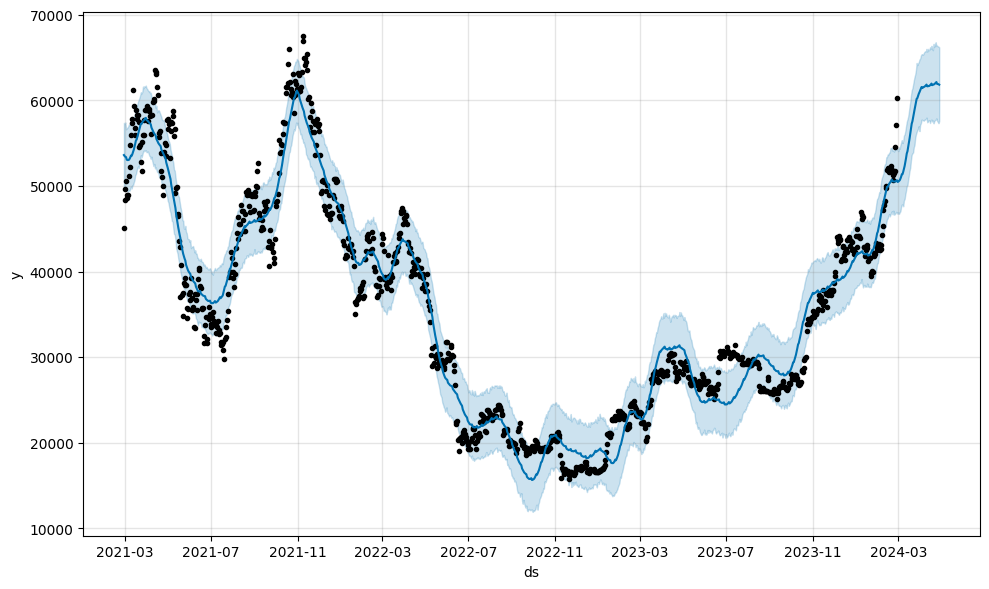

In [99]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

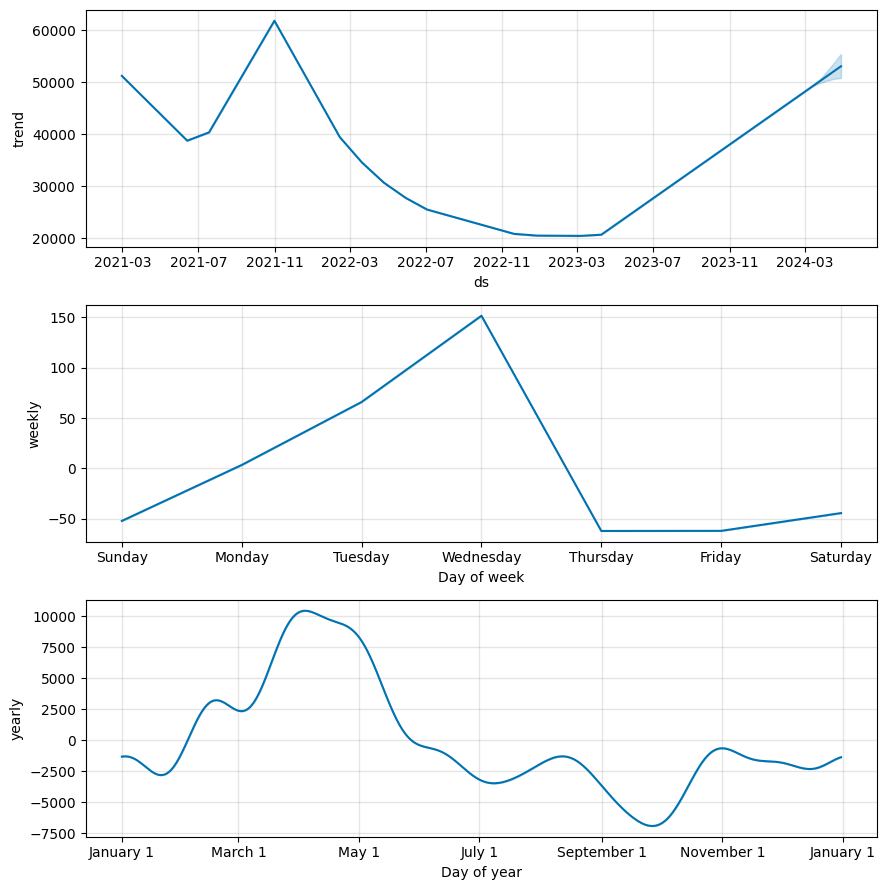

In [100]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [101]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>